In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)
import copy
import pickle

In [2]:
df = pd.read_csv("data/flights_cleaned_no_outlier_iqr_with_delays.csv")

In [3]:
df.head()

,Unnamed: 0,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,weather_type,passengers,month,combined_delay
0,0,2019-10-02,AA,AA_CODESHARE,AA,5330,OH,5330,10581,BGR,"Bangor, ME",11278,DCA,"Washington, DC",543,535.0,-8.0,11.0,546.0,726.0,5.0,749,731.0,-18.0,N,126.0,116.0,100.0,1.0,590.0,0.0,0.0,0.0,0.0,0.0,Rainy,85523.0,1788.0,0.0
1,3,2019-10-02,AA,AA_CODESHARE,AA,3073,OO,3073,10581,BGR,"Bangor, ME",13930,ORD,"Chicago, IL",1328,1324.0,-4.0,17.0,1341.0,1515.0,14.0,1530,1529.0,-1.0,N,182.0,185.0,154.0,1.0,978.0,0.0,0.0,0.0,0.0,0.0,Rainy,85523.0,1788.0,0.0
2,4,2019-10-02,AA,AA_CODESHARE,AA,4023,MQ,4023,10581,BGR,"Bangor, ME",12953,LGA,"New York, NY",1449,1449.0,0.0,13.0,1502.0,1612.0,2.0,1629,1614.0,-15.0,N,100.0,85.0,70.0,1.0,378.0,0.0,0.0,0.0,0.0,0.0,Rainy,85523.0,1788.0,0.0
3,5,2019-10-02,G4,G4,G4,2119,G4,2119,10581,BGR,"Bangor, ME",14761,SFB,"Sanford, FL",1301,1308.0,7.0,7.0,1315.0,1554.0,5.0,1623,1559.0,-24.0,N,202.0,171.0,159.0,1.0,1299.0,0.0,0.0,0.0,0.0,0.0,Rainy,85523.0,1788.0,0.0
4,7,2019-10-02,AA,AA_CODESHARE,AA,4730,PT,4730,10581,BGR,"Bangor, ME",14100,PHL,"Philadelphia, PA",1001,951.0,-10.0,9.0,1000.0,1127.0,7.0,1149,1134.0,-15.0,N,108.0,103.0,87.0,1.0,473.0,0.0,0.0,0.0,0.0,0.0,Rainy,85523.0,1788.0,0.0


# Prepare data for feature selection

# Feature selection

In [4]:
# https://scikit-learn.org/stable/modules/feature_selection.html

In [5]:
## After testing, found most suitable columns and will remap for final modelling

In [6]:
very_important_columns = [ # ran with what the test data can do
    'fl_date', # get month and bin
#     'op_unique_carrier', # most extensive name list
#     'origin', # need 'origin' to merge weather but already merged! ;)
#     'dest_airport_id', # not sure about this one
    'crs_dep_time', # bin times
#     'dep_time', # only using in TRAIN, to learn how other columns affect this
#     'crs_arr_time',
#     'arr_time', # only using in TRAIN, to learn how other columns affect this
    'weather_type', # add weight values
#     'passengers', # not sure about this one
    'arr_delay', # so we can make a target column...
    'distance',
    'air_time',
    
] # important columns seem to be weather(4), time(bin), month(constant)
'''
According to plots:
Weather weight: Snow=10, Rain=5, Cloudy=2, Sunny=1
Time weight: 0-500 = 1, 501-1000 = 8, 1001-1500 = 10, 1501-2000 = 8, 2001 > = 5
Month weight = Oct = 1, Nov, Jan = 5, Dec = 10
'''

'\nAccording to plots:\nWeather weight: Snow=10, Rain=5, Cloudy=2, Sunny=1\nTime weight: 0-500 = 1, 501-1000 = 8, 1001-1500 = 10, 1501-2000 = 8, 2001 > = 5\nMonth weight = Oct = 1, Nov, Jan = 5, Dec = 10\n'

In [7]:
df_ = df.filter(items=very_important_columns)

In [8]:
df_.head()

,fl_date,crs_dep_time,weather_type,arr_delay,distance,air_time
0,2019-10-02,543,Rainy,-18.0,590.0,100.0
1,2019-10-02,1328,Rainy,-1.0,978.0,154.0
2,2019-10-02,1449,Rainy,-15.0,378.0,70.0
3,2019-10-02,1301,Rainy,-24.0,1299.0,159.0
4,2019-10-02,1001,Rainy,-15.0,473.0,87.0


In [9]:
# make a copy of dataframe
scaled_df = df_.copy()

col_names = ['distance', 'air_time']
features = scaled_df[col_names]

# Use scaler of choice; here Standard scaler is used
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_df[col_names] = features

In [10]:
df_ = scaled_df

# remapping crs_dep_time

In [11]:
# Time weight: 0-500 = 1, 501-1000 = 8, 1001-1500 = 10, 1501-2000 = 8, 2001 > = 5
df_.crs_dep_time = df_.crs_dep_time // 100
crs_dep_time_remap = {
    0: 0.10,
    1: 0.10, 
    2: 0.10,
    3: 0.10, 
    4: 0.10,
    5: 0.10, 
    6: 0.40,
    7: 0.40, 
    8: 0.40,
    9: 0.40, 
    10: 0.40,
    11: 0.50, 
    12: 0.50,
    13: 0.50, 
    14: 0.50,
    15: 0.50, 
    16: 0.40,
    17: 0.40,
    18: 0.40,
    19: 0.40, 
    20: 0.40,
    21: 0.20, 
    22: 0.20, 
    23: 0.20
}
df_["dep_time_hour_weight"] = df_.crs_dep_time.map(crs_dep_time_remap)

In [12]:
df_.head()

,fl_date,crs_dep_time,weather_type,arr_delay,distance,air_time,dep_time_hour_weight
0,2019-10-02,5,Rainy,-18.0,-0.298440,-0.105994,0.1
1,2019-10-02,13,Rainy,-1.0,0.372536,0.676949,0.5
2,2019-10-02,14,Rainy,-15.0,-0.665055,-0.540963,0.5
3,2019-10-02,13,Rainy,-24.0,0.927647,0.749444,0.5
4,2019-10-02,10,Rainy,-15.0,-0.500770,-0.294480,0.4


In [13]:
df_.isna().sum()

fl_date                 0
crs_dep_time            0
weather_type            0
arr_delay               0
distance                0
air_time                0
dep_time_hour_weight    0
dtype: int64

In [14]:
df_ = df_.dropna()

# remapping fl_date to month

In [15]:
df_["month"] = [ i [5:7] for i in df_.fl_date ]
# change to datetime and get day of week

In [16]:
df_.head()

,fl_date,crs_dep_time,weather_type,arr_delay,distance,air_time,dep_time_hour_weight,month
0,2019-10-02,5,Rainy,-18.0,-0.298440,-0.105994,0.1,10
1,2019-10-02,13,Rainy,-1.0,0.372536,0.676949,0.5,10
2,2019-10-02,14,Rainy,-15.0,-0.665055,-0.540963,0.5,10
3,2019-10-02,13,Rainy,-24.0,0.927647,0.749444,0.5,10
4,2019-10-02,10,Rainy,-15.0,-0.500770,-0.294480,0.4,10


In [17]:
# don't drop next time
df_ = df_.drop(labels="fl_date", axis=1)

In [18]:
df_

,crs_dep_time,weather_type,arr_delay,distance,air_time,dep_time_hour_weight,month
0,5,Rainy,-18.0,-0.298440,-0.105994,0.1,10
1,13,Rainy,-1.0,0.372536,0.676949,0.5,10
2,14,Rainy,-15.0,-0.665055,-0.540963,0.5,10
3,13,Rainy,-24.0,0.927647,0.749444,0.5,10
4,10,Rainy,-15.0,-0.500770,-0.294480,0.4,10
...,...,...,...,...,...,...,...
2073110,18,Sunny,-10.0,-1.076633,-1.091923,0.4,01
2073111,10,Sunny,-30.0,-1.076633,-1.106422,0.4,01
2073112,13,Rainy,-11.0,-1.005731,-0.917935,0.5,01
2073113,19,Rainy,-19.0,-1.005731,-0.903436,0.4,01


In [19]:
df_.month.unique()

array(['10', '11', '12', '01'], dtype=object)

In [20]:
# # Month weight = Oct = 1, Nov, Jan = 5, Dec = 10
# month_remap = { 
#     '10': 0.10,
#     '11': 0.50, 
#     '12': 1,
#     '01': 0.50
# }
# df_["month_weight"] = df_.month.map(month_remap)

In [21]:
# df_.head() # see month weight

# remapping weather

In [22]:
df_.weather_type.unique()

array(['Rainy', 'Sunny', 'Snowy', 'Cloudy'], dtype=object)

In [23]:
# Weather weight: Snow=10, Rain=5, Cloudy=2, Sunny=1
weather_remap = {
    "Rainy": 0.40,
    "Sunny": 0.05, 
    "Snowy": 0.80,
    "Cloudy": 0.10
}
df_['weather_weight'] = df_.weather_type.map(weather_remap)

In [24]:
df_ = pd.get_dummies(df_, columns=['weather_type'], drop_first=True)
# df_ = pd.get_dummies(df_, columns=['op_unique_carrier'], drop_first=True)
df_ = pd.get_dummies(df_, columns=['month'], drop_first=True)

In [25]:
df_.head()

,crs_dep_time,arr_delay,distance,air_time,dep_time_hour_weight,weather_weight,weather_type_Rainy,weather_type_Snowy,weather_type_Sunny,month_10,month_11,month_12
0,5,-18.0,-0.298440,-0.105994,0.1,0.4,1,0,0,1,0,0
1,13,-1.0,0.372536,0.676949,0.5,0.4,1,0,0,1,0,0
2,14,-15.0,-0.665055,-0.540963,0.5,0.4,1,0,0,1,0,0
3,13,-24.0,0.927647,0.749444,0.5,0.4,1,0,0,1,0,0
4,10,-15.0,-0.500770,-0.294480,0.4,0.4,1,0,0,1,0,0


In [26]:
# # Used dummies before, got 0.03 to 0.06 results. Trying feature selection/engineering next.
# df_dummies = pd.get_dummies(df_, columns=['weather_type'])
# df_dummies = pd.get_dummies(df_dummies, columns=['op_unique_carrier'])
# df_dummies = pd.get_dummies(df_dummies, columns=['origin'])

In [27]:
df_.head()

,crs_dep_time,arr_delay,distance,air_time,dep_time_hour_weight,weather_weight,weather_type_Rainy,weather_type_Snowy,weather_type_Sunny,month_10,month_11,month_12
0,5,-18.0,-0.298440,-0.105994,0.1,0.4,1,0,0,1,0,0
1,13,-1.0,0.372536,0.676949,0.5,0.4,1,0,0,1,0,0
2,14,-15.0,-0.665055,-0.540963,0.5,0.4,1,0,0,1,0,0
3,13,-24.0,0.927647,0.749444,0.5,0.4,1,0,0,1,0,0
4,10,-15.0,-0.500770,-0.294480,0.4,0.4,1,0,0,1,0,0


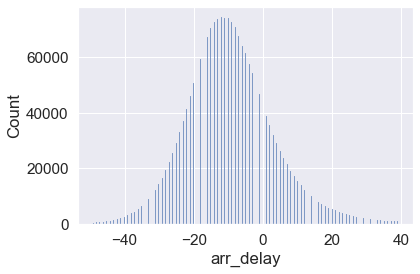

In [28]:
sns.histplot(df_.arr_delay);

# remove outliers

In [29]:
df_.shape

(2073115, 12)

In [30]:
# Get rid of 0 y's
# df_ = df_[df_['arr_delay'] != 0] 

In [31]:
df_checkpoint = df_.copy()
# df_checkpoint = df_checkpoint.sample(frac=0.5)

In [32]:
df_checkpoint.columns

Index(['crs_dep_time', 'arr_delay', 'distance', 'air_time',
       'dep_time_hour_weight', 'weather_weight', 'weather_type_Rainy',
       'weather_type_Snowy', 'weather_type_Sunny', 'month_10', 'month_11',
       'month_12'],
      dtype='object')

In [33]:
df_checkpoint.head()

,crs_dep_time,arr_delay,distance,air_time,dep_time_hour_weight,weather_weight,weather_type_Rainy,weather_type_Snowy,weather_type_Sunny,month_10,month_11,month_12
0,5,-18.0,-0.298440,-0.105994,0.1,0.4,1,0,0,1,0,0
1,13,-1.0,0.372536,0.676949,0.5,0.4,1,0,0,1,0,0
2,14,-15.0,-0.665055,-0.540963,0.5,0.4,1,0,0,1,0,0
3,13,-24.0,0.927647,0.749444,0.5,0.4,1,0,0,1,0,0
4,10,-15.0,-0.500770,-0.294480,0.4,0.4,1,0,0,1,0,0


In [34]:
df_checkpoint.shape

(2073115, 12)

In [35]:
df_checkpoint.arr_delay.describe()

count    2.073115e+06
mean    -9.461144e+00
std      1.260616e+01
min     -4.900000e+01
25%     -1.800000e+01
50%     -1.000000e+01
75%     -2.000000e+00
max      3.900000e+01
Name: arr_delay, dtype: float64

In [36]:
Q1_dep = df_checkpoint.arr_delay.quantile(0.20)
Q3_dep = df_checkpoint.arr_delay.quantile(0.80)
IQR_dep = Q3_dep - Q1_dep
df_checkpoint = df_checkpoint.loc[(df_checkpoint['arr_delay'] >= (Q1_dep - 1.5*IQR_dep))\
                                     & (df_checkpoint['arr_delay'] <= Q3_dep + 1.5*IQR_dep)]

In [37]:
df_checkpoint.arr_delay.describe()

count    2.056026e+06
mean    -9.769760e+00
std      1.204783e+01
min     -4.700000e+01
25%     -1.800000e+01
50%     -1.000000e+01
75%     -2.000000e+00
max      2.800000e+01
Name: arr_delay, dtype: float64

In [38]:
df_checkpoint.shape

(2056026, 12)

In [39]:
X = df_checkpoint[df_checkpoint.columns.difference(['arr_delay'])]
y = df_checkpoint["arr_delay"]

In [40]:
print(X.shape)
print(y.shape)

(2056026, 11)
(2056026,)


In [41]:
y = pd.DataFrame(y)

In [42]:
# make all y neg values, 0
# y[y < 0] = 0

In [43]:
y.shape

(2056026, 1)

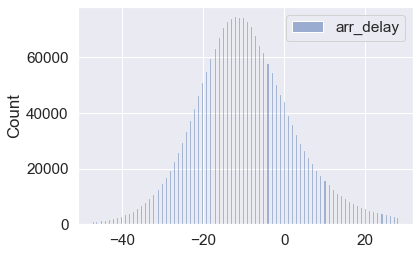

In [44]:
sns.histplot(y);

In [45]:
from scipy import stats
shapiro_test = stats.shapiro(y)
print(shapiro_test.statistic)
print(shapiro_test.pvalue)

0.9887945652008057
0.0


/Users/louisrossi/opt/anaconda3/envs/ml/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [46]:
from numpy import mean
from numpy import std

print('mean=%.3f stdv=%.3f' % (mean(y), std(y)))

mean=-9.770 stdv=12.048


/Users/louisrossi/opt/anaconda3/envs/ml/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


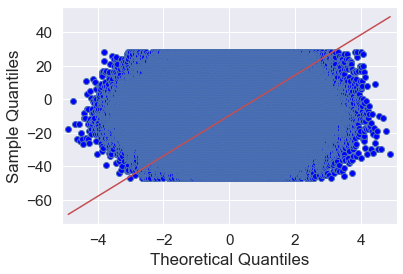

In [47]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
# q-q plot
qqplot(y, line='s')
plt.show()

In [48]:
from scipy.stats import shapiro

stat, p = shapiro(y)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.989, p=0.000
Sample does not look Gaussian (reject H0)


/Users/louisrossi/opt/anaconda3/envs/ml/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


# Smote?

In [49]:
# # check version number
# import imblearn
# # transform the dataset
# from collections import Counter
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import SMOTE 
# oversample = SMOTE()
# X, y = oversample.fit_resample(X, y)

In [50]:
# print(X.shape)
# print(y.shape)

In [51]:
# sns.histplot(y);

In [52]:
# y.arr_delay.mean()

In [53]:
# # remerge y to X... sample frac... resplit.
# X["arr_delay"] = y.arr_delay
# X_checkpoint = X.copy()
# X_checkpoint = X_checkpoint.sample(frac=0.5)

In [54]:
# X = X_checkpoint[X_checkpoint.columns.difference(['arr_delay'])]
# y = X_checkpoint["arr_delay"]

In [55]:
# y = pd.DataFrame(y)

In [56]:
# print(X.shape)
# print(y.shape)

# Smote end

## Main Task: Regression Problem
The target variable is ARR_DELAY. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.
For example, variables CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.
We will be evaluating your models by predicting the ARR_DELAY for all flights 1 week in advance.

#### linear / logistic / multinomial logistic regression
#### Naive Bayes
#### Random Forest
#### SVM
#### XGBoost
#### The ensemble of your own choice

In [57]:
# X = X.replace([np.inf, -np.inf], np.nan)
# X = X.dropna()

In [58]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.75,random_state=42)

In [59]:
from sklearn.linear_model import Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import absolute
from numpy import mean
from numpy import std

## feature selection test

In [60]:
# ANOVA feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# define feature selection
fs = SelectKBest(score_func=f_classif, k=4)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

/Users/louisrossi/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(2056026, 4)


# Linear Regression with MinMax Pipeline

In [61]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
# prepare the model with input scaling
pipeline = Pipeline(steps=[('normalize', MinMaxScaler()), ('model', LinearRegression())])
# fit pipeline
pipeline.fit(X_train, y_train)
# make predictions
y_pred = pipeline.predict(X_test)
from sklearn import metrics
print(pipeline.score(X_train, y_train))

0.07024240934557124


## Naive Bayes Model

In [62]:
# 0.0361 score
from sklearn import naive_bayes
gnb = naive_bayes.GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))

# save the model to disk
filename = 'finalized_Naive_Bayes_imb_all.sav'
pickle.dump(gnb, open(filename, 'wb'))

/Users/louisrossi/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.032832237693260984


## Lasso (not good)

In [63]:
# # 0.060 score unscaled: scaled data 0.041: after trimming huge 0.034
# model = Lasso(alpha=0.5)
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# # force scores to be positive
# scores = absolute(scores)
# print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

## Random Forest Classifier Model

In [64]:
# 0.036
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# 0.03 score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

# save the model to disk
filename = 'finalized_Random_forest_imb_all.sav'
pickle.dump(clf, open(filename, 'wb'))

/var/folders/wg/4yj17hrn3q9g_27l8zsxxy5m0000gn/T/ipykernel_13861/2419498267.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


0.0356687749388627


## Gridsearch cells. Do not run.

In [65]:
# # parameter grid
# parameter_candidates = {
#     'n_estimators':[270, 285, 300],
#     'max_depth':[3]
# }
# from sklearn import datasets, svm
# from sklearn.model_selection import GridSearchCV
# grid_result = GridSearchCV(clf, param_grid=parameter_candidates, n_jobs=-1)
# the_fit = grid_result.fit(X_train, y_train.values.ravel())
# bestresult = grid_result.best_estimator_

In [66]:
# # View the accuracy score best run: MD3, nest300 score:0.04
# print('Best score for data1:', grid_result.best_score_) 
# print(grid_result.best_params_)
# print(bestresult)
# grid_result.score(X_train, y_train)

## Random Forest tuned

In [67]:
# # 0.043
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification
# clf2 = RandomForestClassifier(max_depth=3, n_estimators=285, random_state=42)
# clf2.fit(X_train, y_train)

# y_pred = clf2.predict(X_test)

# #  score
# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y_test,y_pred)
# print(accuracy)
# # save the model to disk? No. Same as first RF

## Linear/Log Regression

In [68]:
# 0.05
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_train, y_train))

# save the model to disk
filename = 'finalized_LinReg_imb_all.sav'
pickle.dump(reg, open(filename, 'wb'))

0.07024254792067819


In [69]:
reg.coef_

array([[ 15.91397847,   0.05688175,  -2.36089621, -16.14334154,
          0.83313602,  -0.23786641,   0.39052248,   1.7139164 ,
          2.00382194,   1.5855534 ,   1.83757261]])

In [70]:
reg.intercept_

array([-11.74355463])

## Decision Tree

In [71]:
# 0.08 
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
clf_dt = DecisionTreeClassifier()
clf_dt = clf_dt.fit(X_train,y_train)
y_pred = clf_dt.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# save the model to disk
filename = 'finalized_Decision_Tree_imb_all.sav'
pickle.dump(clf_dt, open(filename, 'wb'))

Accuracy: 0.03219995058433056


In [72]:
y_pred[:50]

array([-14., -21., -18., -14.,  -1.,  17., -24., -14., -10.,  -4., -18.,
       -27., -21., -25.,   8., -26.,  -1., -18., -18.,  17.,  17., -11.,
       -19., -11.,   0.,  -5.,  -6., -11.,  -3., -15.,  -5.,   0., -18.,
       -29., -27., -11., -13., -33., -10.,   4., -13.,   2.,  -6., -18.,
        -8., -13., -26., -21., -12., -10.])

## SVM (do not run)

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
scaler = StandardScaler()
scaler.fit(df_checkpoint)
X = scaler.transform(df_checkpoint.loc[:, df_checkpoint.columns != 'arr_delay'])
X = df_checkpoint[df_checkpoint.columns.difference(['arr_delay'])]
y = df_checkpoint["arr_delay"]

In [74]:
from sklearn import svm
clf = svm.SVC(kernel='poly')
clf.fit(X_train, y_train.values.ravel())
y_pred = clf.predict(X_test)

In [75]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test, y_pred)

In [76]:
# clf2 = svm.SVC(kernel='rbf')
# clf2.fit(X_train, y_train.values.ravel())
# y_pred2 = clf2.predict(X_test)

In [77]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test, y_pred2)

In [78]:
# clf3 = svm.SVC(kernel='sigmoid')
# clf3.fit(X_train, y_train.values.ravel())
# y_pred3 = clf3.predict(X_test)

In [79]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test, y_pred3)

In [80]:
# from sklearn import metrics
# print("Accuracy poly:",metrics.accuracy_score(y_test, y_pred))
# print("Accuracy rbg:",metrics.accuracy_score(y_test, y_pred2))
# print("Accuracy sigmoid:",metrics.accuracy_score(y_test, y_pred3))

## XGBoost

In [81]:
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# data_dmatrix = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', # not XGBClassifier() bc regression.
#                           colsample_bytree = 0.3, 
#                           learning_rate = 0.1,
#                           max_depth = 3, 
#                           alpha = 10, 
#                           n_estimators = 250)
# err about categorical values